In [1]:
%reload_ext autoreload
%autoreload 2

In [13]:
import polars as pl 
from pathlib import Path
from datetime import datetime

from sklearn.metrics import mean_absolute_error

from src.plots import plot_ts
from src.paths import *
from src.config import TODAY_IS, ModelConfig
from src.dwh import run_database_operation
from src.train import split_into_train_and_test
from src.pipeline import model

# Load from DWH

In [3]:
df = run_database_operation(
    operation="fetch_pickup_data",
    from_date=datetime(2022, 1, 1),
    to_date=TODAY_IS,
    pickup_locations=[43]
)


train, test = split_into_train_and_test(df)

In [4]:
train.shape, test.shape, train.head()


((426, 3),
 (90, 3),
 shape: (5, 3)
 ┌──────────────────────┬────────────────────┬────────────┐
 │ pickup_datetime_hour ┆ pickup_location_id ┆ num_pickup │
 │ ---                  ┆ ---                ┆ ---        │
 │ date                 ┆ i16                ┆ f64        │
 ╞══════════════════════╪════════════════════╪════════════╡
 │ 2022-01-01           ┆ 43                 ┆ 864.0      │
 │ 2022-01-02           ┆ 43                 ┆ 991.0      │
 │ 2022-01-03           ┆ 43                 ┆ 1246.0     │
 │ 2022-01-04           ┆ 43                 ┆ 1334.0     │
 │ 2022-01-05           ┆ 43                 ┆ 1306.0     │
 └──────────────────────┴────────────────────┴────────────┘)

## Baseline model

- Features: 1d, 7d, 14d, 28d
- Prediction: Average of features
- Forecast horizon: Next day

In [14]:
model.fit(train, train[[ModelConfig.TS_INDEX, ModelConfig.TARGET]])
predictions = model.predict(train)
test_predictions = model.predict(test)


In [19]:
train_with_predicitions = (
    train.join(predictions, on=ModelConfig.TS_INDEX, how="inner")
    .with_columns(
        (pl.col("prediction") - pl.col("num_pickup")).alias("residual")
    )
)

test_with_predictions = test.join(test_predictions, on=ModelConfig.TS_INDEX, how="inner")



plot_ts(train_with_predicitions, ["num_pickup", "prediction"])
plot_ts(train_with_predicitions, ["residual"])
plot_ts(test_with_predictions, ["num_pickup", "prediction"])


train_mae = mean_absolute_error(train_with_predicitions["num_pickup"], train_with_predicitions["prediction"])
test_mae = mean_absolute_error(test_with_predictions["num_pickup"], test_with_predictions["prediction"])

print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")




Train MAE: 150.11, Test MAE: 122.73


## Residuals Diagnostic

Main conclusions
- Residuals mean is not zero but negative. This implies forecasts have a downward bias. 
- Residuals show some autocorrelation for recent lags, meaning there´s still some point of improvement.
- Visual inspection suggest residuals are not normally distributed, meaning that we would need alternative approaches to model the uncertainty of our predictions.


Action points
- To reduce bias, we could simply take away the bias value. 
- For the autocorrelation, we could try a proper time series model 
- For the prediction intervals, we can use bootstrapping

Mean: -5.82, Std: 209.46


C:\Users\selaf\AppData\Local\Temp\ipykernel_15396\4263196343.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



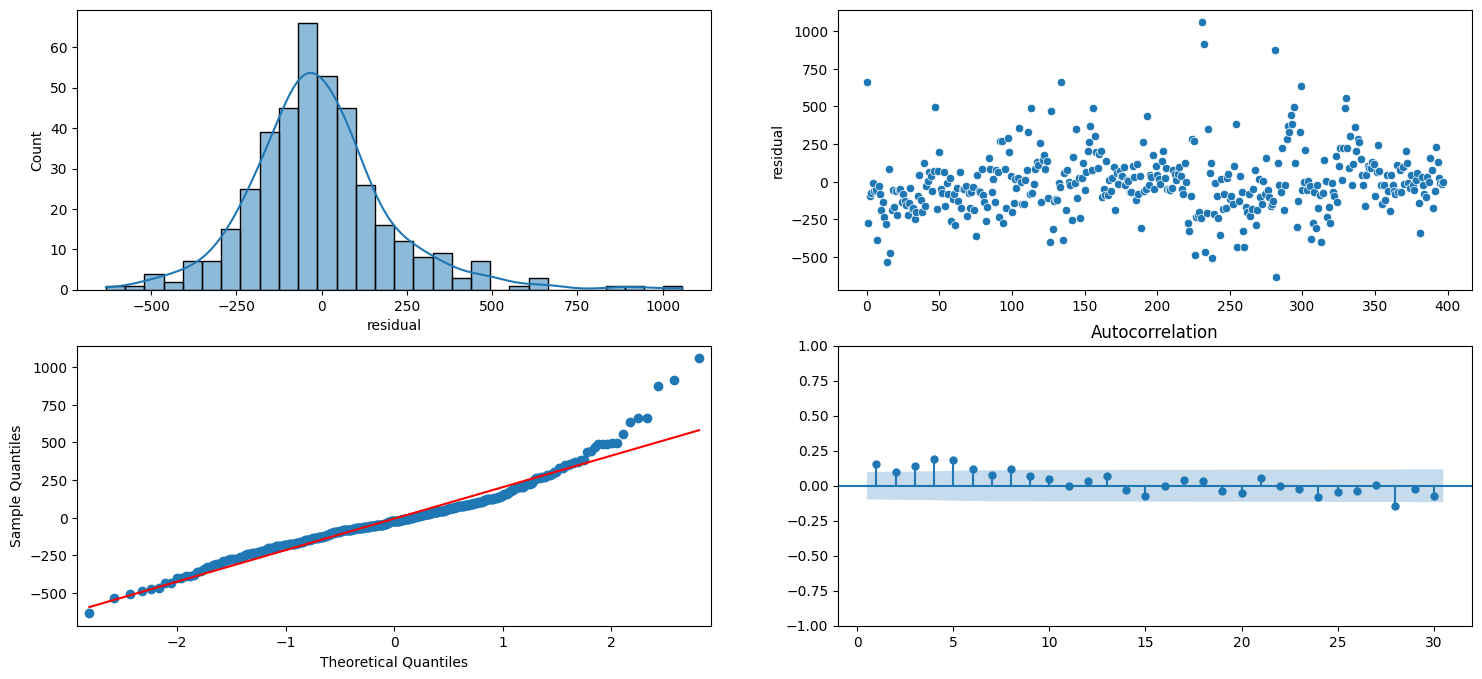

In [49]:
import seaborn as sns 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
from statsmodels.graphics import tsaplots

mean, std = train_with_predicitions["residual"].mean(), train_with_predicitions["residual"].std()
print(
    f"Mean: {mean:.2f}, Std: {std:.2f}"
)
fig, axs = plt.subplots(2,2, figsize=(18,8))
sns.histplot(train_with_predicitions["residual"].to_pandas(), kde=True, ax=axs[0,0])
sns.scatterplot(train_with_predicitions["residual"].to_pandas(), ax=axs[0,1])
sm.qqplot(train_with_predicitions["residual"].to_pandas(), line="s", ax=axs[1,0])
tsaplots.plot_acf(train_with_predicitions["residual"].to_pandas(), lags=30, ax=axs[1,1], zero=False)

fig.show()


## Boostrapping Prediction Intervals
